In [1]:
%reset
import os

# Change the current working directory to the desired path
os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')

import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')

%load_ext autoreload
%autoreload 2




In [2]:
from colossus.cosmology import cosmology
cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
cosmo = cosmology.setCosmology('myCosmo', **cosmo_params_dict)
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['theta_co'] = 0.1
sim_params_dict['theta_ej'] = 4.0
sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['M1_starcga'] = 2.5e11
sim_params_dict['epsilon_rt'] = 4.0
sim_params_dict['Mc0'] = 10**14.83
# sim_params_dict['Mc0'] = 10**1
sim_params_dict['nu_z'] = 0
sim_params_dict['nu_M'] = 0
sim_params_dict['Mstar0'] = 10**13
sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.8
sim_params_dict['cosmo'] = cosmo_params_dict
sim_params_dict['beam_fwhm_arcmin'] = 1.6




In [3]:
halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 10, 32
halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.01, 2.5, 16
halo_params_dict['Mmin'], halo_params_dict['Mmax'], halo_params_dict['nM'] = 1e12, 1e15, 16
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 2, 9, 16
halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**16, 512
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.1
halo_params_dict['mdef'] = '200c'




In [4]:
from astropy.io import fits
df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/sim_3x2pt_simulated_DV_PKproject_values_bestfit_maglim_3x2LCDM_final.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 4
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-3)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-3)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-3)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-3)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True

df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DES_ACT_full_data_theorycov_2.5.fits')
theta_data = df_data['compton_shear'].data['ANG'][0:20]


analysis_dict['angles_data_array'] = jnp.array(theta_data)



In [5]:
from setup_power_spectra_jit import setup_power_BCMP
from get_power_spectra_jit import get_power_BCMP
from get_corr_func_jit import get_corrfunc_BCMP


In [6]:
setup_power_BCMP_test = setup_power_BCMP(sim_params_dict, halo_params_dict, num_points_trapz_int=64)
get_power_BCMP_obj_test = get_power_BCMP(sim_params_dict, halo_params_dict, analysis_dict,setup_power_BCMP_obj=setup_power_BCMP_test, verbose_time=True)
get_corrfunc_BCMP_test = get_corrfunc_BCMP(sim_params_dict, halo_params_dict, analysis_dict, get_power_BCMP_obj=get_power_BCMP_obj_test, verbose_time=True)



2023-07-15 17:03:43.978343: W external/xla/xla/service/gpu/nvptx_compiler.cc:596] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.91). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Time for setup_power_BCMP:  7.152557373046875e-07
Time for computing Wk_mat:  0.5870382785797119
Time for computing p_logc_Mz:  0.5516138076782227
Time for computing Cl_kappa_y_1h_mat:  0.3842291831970215
Time for computing Cl_kappa_y_2h_mat:  0.10941648483276367
Time for computing Cl_kappa_kappa_1h_mat:  0.2812690734863281
Time for computing Cl_kappa_kappa_2h_mat:  0.11853146553039551
Time for computing Cl_kappa_kappa_nfw_1h_mat:  0.19307160377502441
Total time for computing all Cls:  2.558814764022827
Time for setup_power_BCMP:  7.152557373046875e-07
Time for gty Hankel transform:  0.33533573150634766
Time for xip Hankel transform:  0.2923426628112793
Time for xim Hankel transform:  0.23514342308044434


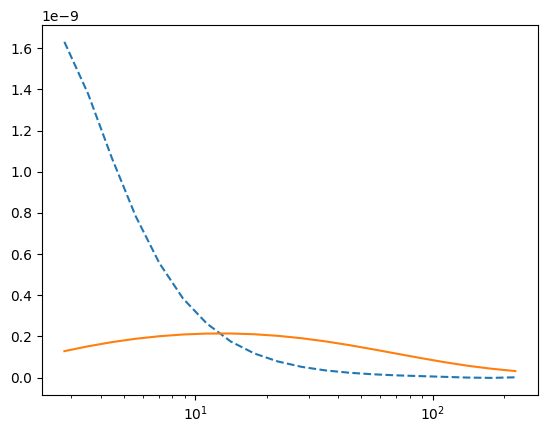

In [7]:
# get_power_BCMP_test.p_logc_Mz.shape
pl.figure()
pl.plot(get_corrfunc_BCMP_test.angles_data_array, get_corrfunc_BCMP_test.gty_1h_out_mat[:,3], ls='--')
pl.plot(get_corrfunc_BCMP_test.angles_data_array, get_corrfunc_BCMP_test.gty_2h_out_mat[:,3], ls='-')
pl.xscale('log')
# pl.xlim(0.8,100)
# pl.ylim(0.0,2e-9)
# pl.yscale('log')




In [7]:
# df_data['compton_shear'].data['VALUE']
C = jnp.array(df_data['COVMAT'].data[400:,400:])
# P = jnp.linalg.inv(C)
P = jnp.array(np.linalg.inv(df_data['COVMAT'].data[400:,400:]))
data_vec = jnp.array(df_data['compton_shear'].data['VALUE'])




In [8]:
from numpyro.distributions.transforms import AffineTransform
import numpyro.distributions as dist
def Uniform(name, min_value, max_value):
    """ Creates a Uniform distribution in target range from a base
    distribution between [-3, 3]
    """
    s = (max_value - min_value) / 6.
    return numpyro.sample(
            name,
            dist.TransformedDistribution(
                dist.Uniform(-3., 3.),
                AffineTransform(min_value + 3.*s, s),
            ),
        )


/mnt/home/spandey/ceph/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from get_corr_func_jit import get_corrfunc_BCMP
import numpyro
def model():
    #  Cosmological params
    # theta_ej = Uniform('theta_ej', 1.0, 6.0)
    lg10Mc0 = Uniform('lg10Mc0', 12.0, 15.0)
    nuz_Mc0 = Uniform('nuz_Mc0', 0.0, 2.0)
    # nuM_Mc0 = Uniform('nuM_Mc0', 0.0, 2.0)
    alpha_nt = Uniform('alpha_nt', 0.01, 0.4)
    # n_nt = Uniform('n_nt', 0.6, 1.0)
    
    # sim_params_dict['theta_ej'] = theta_ej
    sim_params_dict['Mc0'] = 10**lg10Mc0
    sim_params_dict['nu_z'] = nuz_Mc0
    # sim_params_dict['nu_M'] = nuM_Mc0   
    sim_params_dict['alpha_nt'] = alpha_nt
    # sim_params_dict['n_nt'] = n_nt
    
    # Now that params are defined, here is the forward model
    get_corrfunc_BCMP_obj = get_corrfunc_BCMP(sim_params_dict, halo_params_dict, analysis_dict,num_points_trapz_int=32)
    theory = get_corrfunc_BCMP_obj.gty_out_mat.flatten()
    
    return numpyro.sample('cl', dist.MultivariateNormal(theory, 
                                                        precision_matrix=P,
                                                        covariance_matrix=C))





In [10]:
from numpyro.handlers import seed, trace, condition
# Now we condition the model on obervations
observed_model = condition(model, {'cl': data_vec})



In [11]:
import numpyro
from numpyro.infer.reparam import LocScaleReparam, TransformReparam

def config(x):
    if type(x['fn']) is dist.TransformedDistribution:
        return TransformReparam()
    elif type(x['fn']) is dist.Normal and ('decentered' not in x['name']):
        return LocScaleReparam(centered=0)
    else:
        return None

observed_model_reparam = numpyro.handlers.reparam(observed_model, config=config)




In [12]:
nuts_kernel = numpyro.infer.NUTS(observed_model_reparam,
                                 step_size=1e-1, 
                                 init_strategy=numpyro.infer.init_to_median,
                                 dense_mass=True,
                                 max_tree_depth=5)



In [13]:
mcmc = numpyro.infer.MCMC(nuts_kernel, 
                          num_warmup=200, 
                          num_samples=500,
                          num_chains=1,
                          # chain_method='vectorized',
                          chain_method='sequential',                          
                          progress_bar=True)


In [14]:
# !pip uninstall -y mcfit 
numpyro.set_platform("gpu")


In [15]:
import jax

mcmc.run(jax.random.PRNGKey(42))



2023-07-15 16:33:10.899889: W external/xla/xla/service/gpu/nvptx_compiler.cc:596] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.91). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
sample: 100%|██████████| 700/700 [03:48<00:00,  3.06it/s, 3 steps of size 4.66e-01. acc. prob=0.95] 


In [16]:
# !pip install arviz


In [17]:
# import jax
# jax.clear_caches()


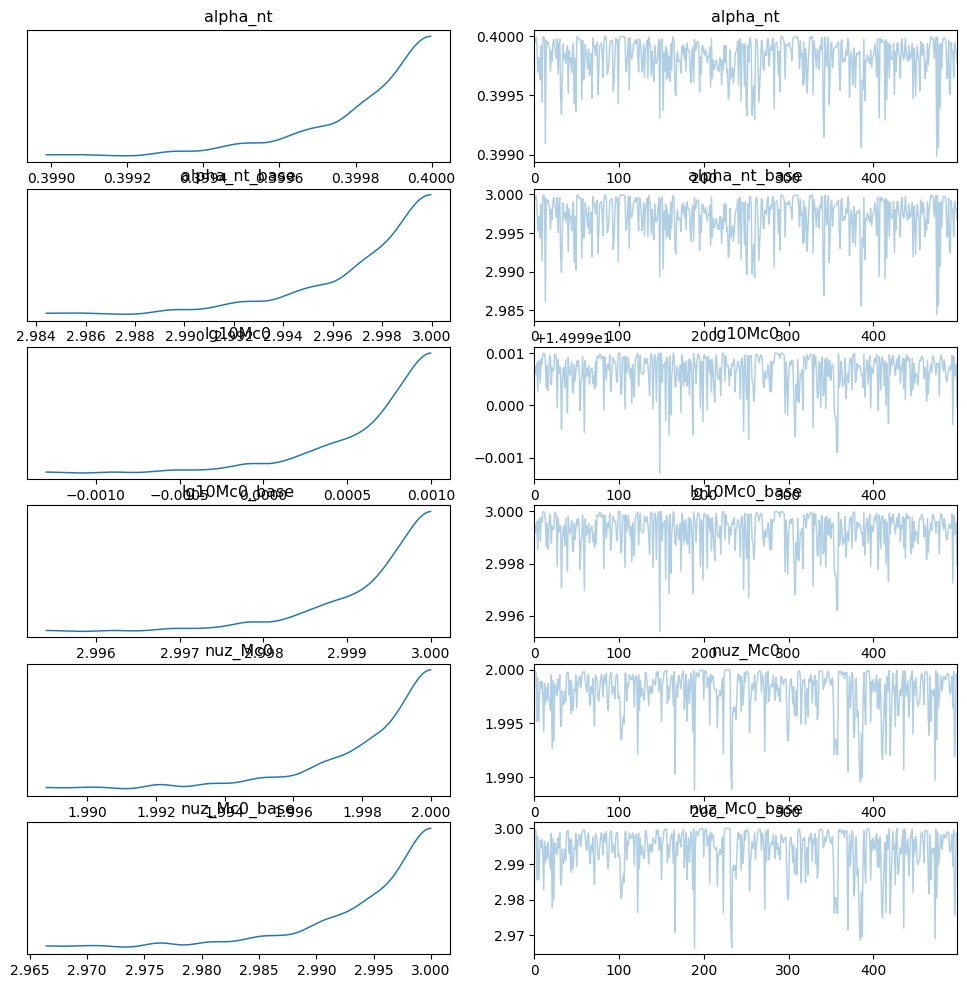

In [19]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data);

In [20]:
s = mcmc.get_samples()

In [21]:
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha_nt_base      3.00      0.00      3.00      2.99      3.00    486.39      1.00
   lg10Mc0_base      3.00      0.00      3.00      3.00      3.00    354.17      1.00
   nuz_Mc0_base      2.99      0.01      3.00      2.98      3.00    247.97      1.00

Number of divergences: 0


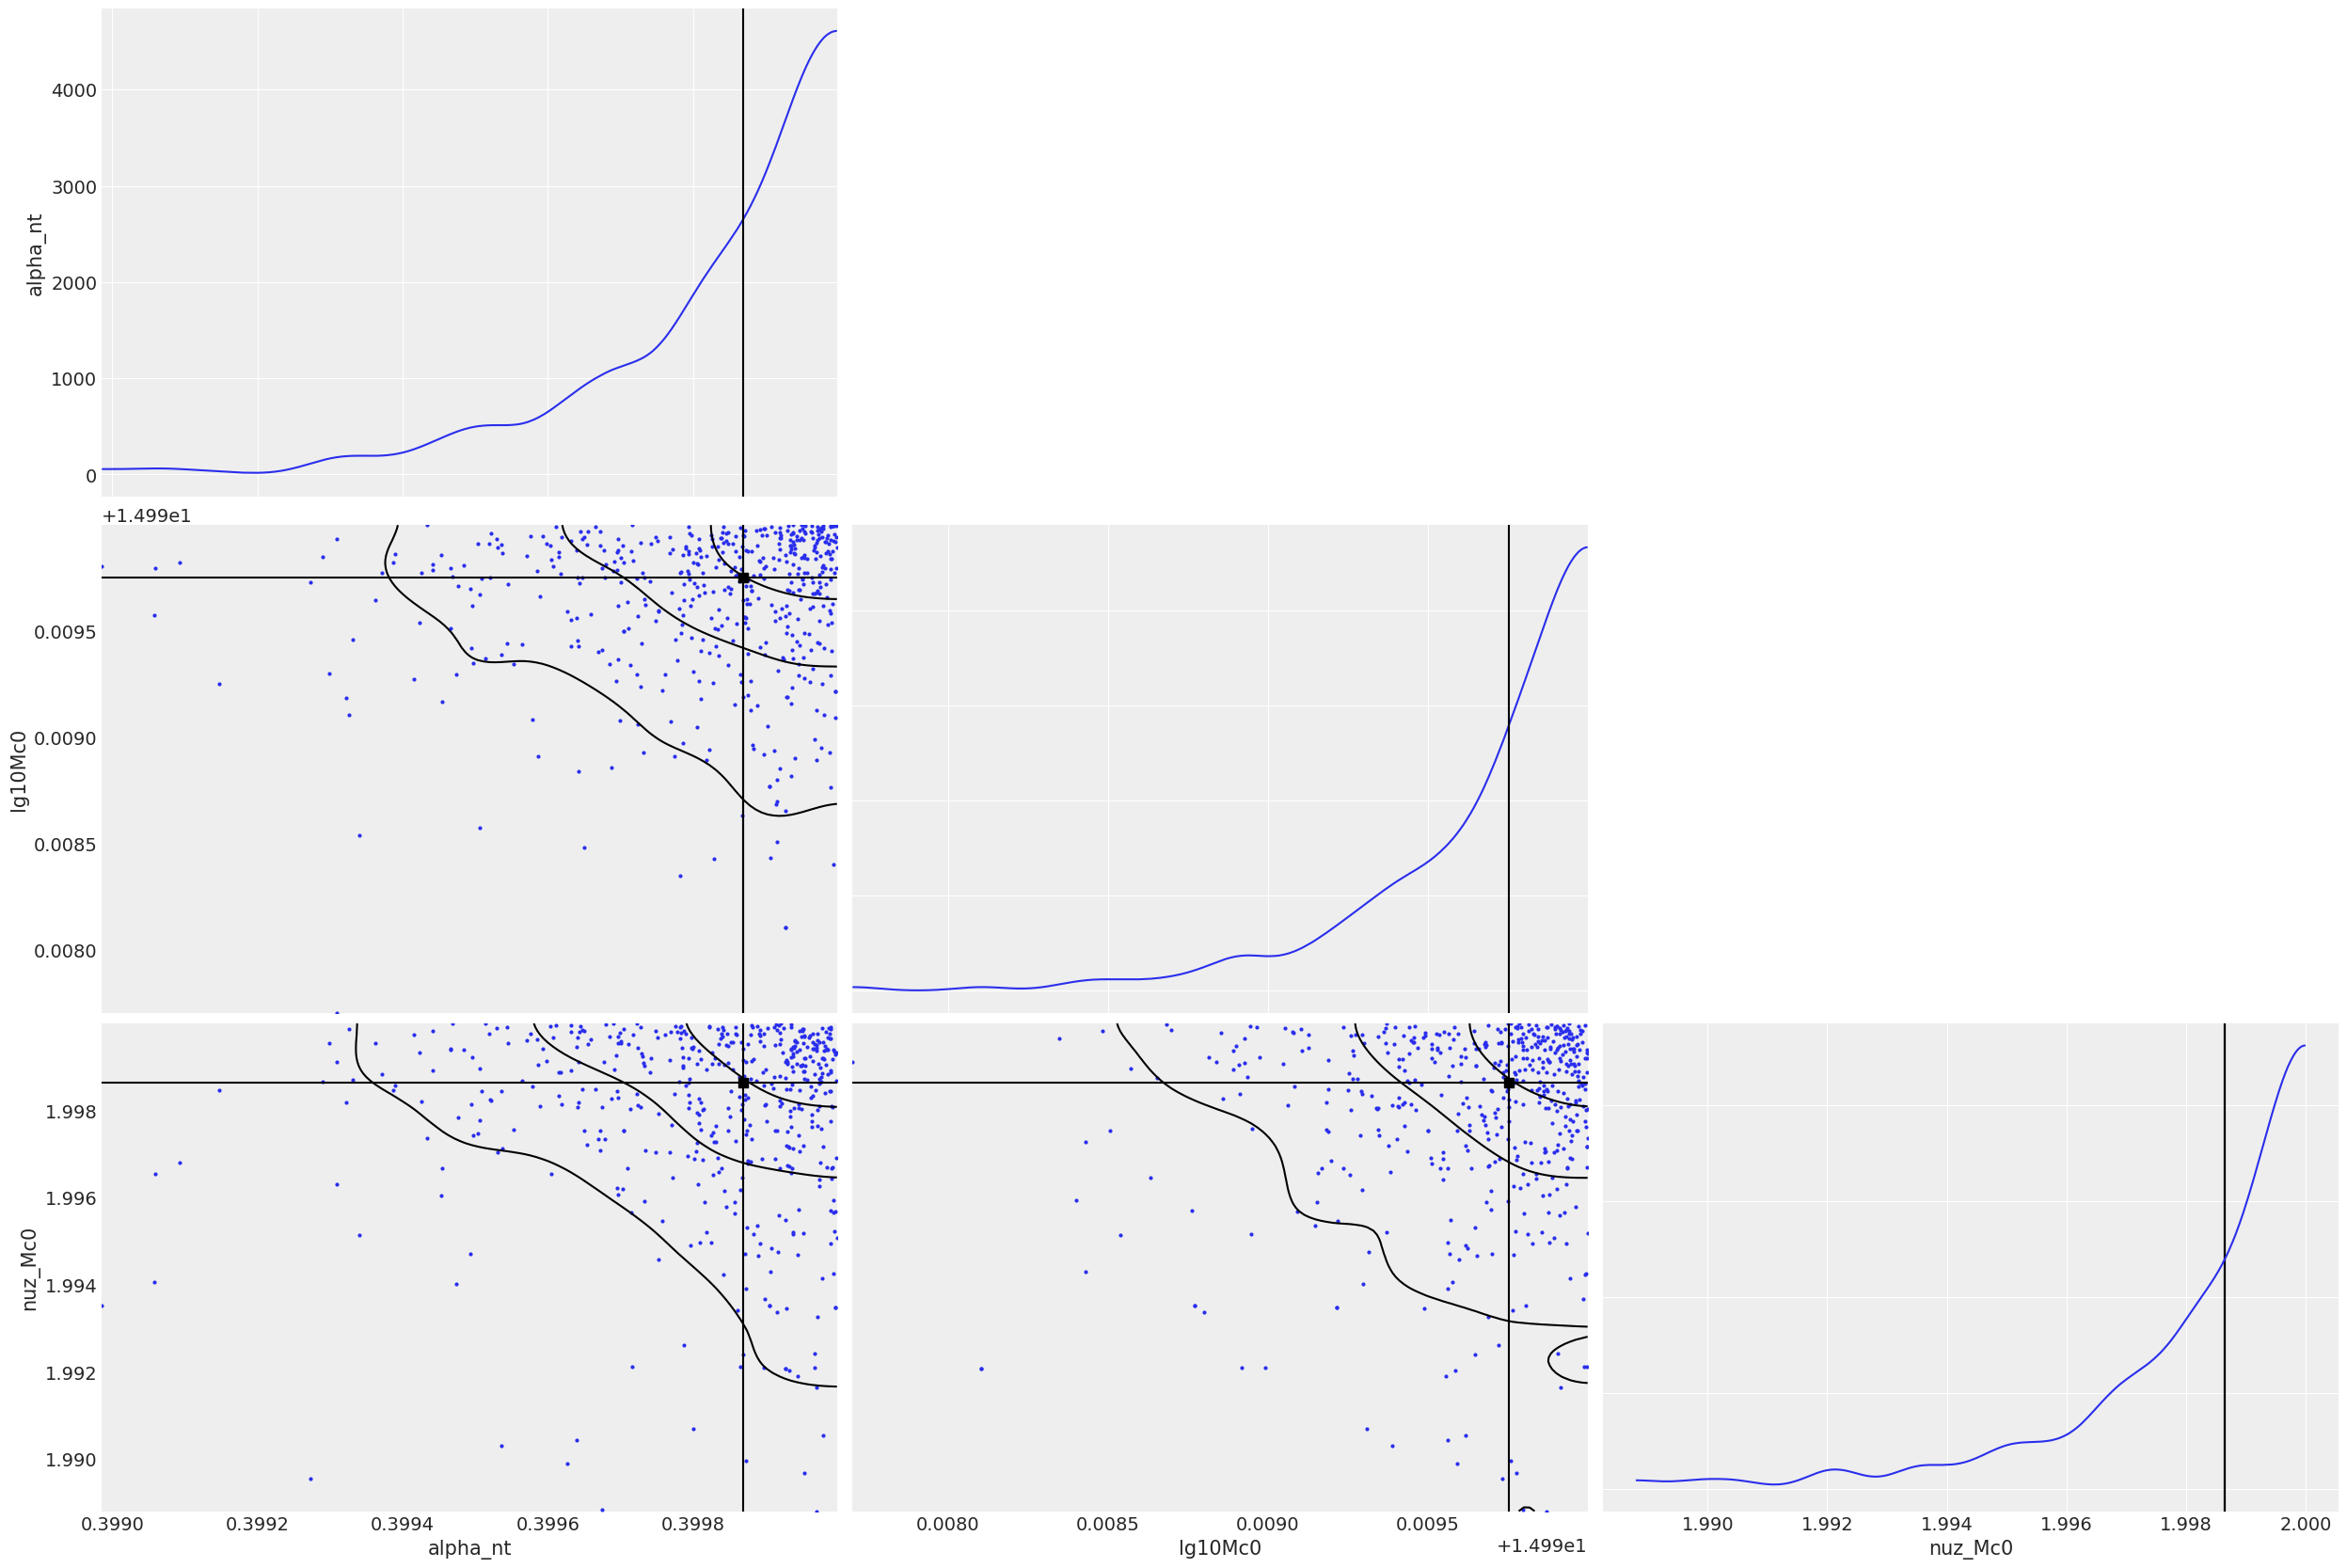

In [22]:
import arviz as az

az.style.use("arviz-darkgrid")

az.plot_pair(
    s,
    kind=["scatter", "kde"],
    var_names=['alpha_nt', 'lg10Mc0', 'nuz_Mc0'],
    kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Blues"},
    },
    marginals=True,
    point_estimate="median",
);